<a href="https://colab.research.google.com/github/jinseriouspark/pricing/blob/main/%5Bdynamic_pricing%5D_02_ecommerce_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic pricing - 02. Ecommerce Example
[reference : chatGPT]

다이나믹 프라이싱은 고객의 수요, 경쟁사의 가격, 재고 수준, 시간 등의 요인에 따라 실시간으로 가격을 조정하는 전략입니다.
이를 통해 수익을 극대화 할 수 있을거에요.
하나의 시나리오를 만들어볼게요. 이커머스 시장에서는 특정 제품의 가격을 시간에 따라 변경하는 전략을 취하고 있어요. 가격이 변동하는 요인은 크게 4가지가 될겁니다.

1. 시간대 (낮 vs 밤)
2. 요일 (주중 vs 주말)
3. 재고 수준 ( 재고가 적을 수록 가격이 상승)
4. 경쟁사의 가격 변화

위의 요인이 담긴 데이터셋을 생성해볼게요. 그 데이터를 기반으로 다이나믹 프라이싱 전략을 구현해보겠습니다.

In [63]:
# 데이터 생성

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# seed
np.random.seed(717)

# 요인4 데이터 생성

time_points = pd.date_range('2024-01-01', periods = 24 * 7, freq = 'H')
hours = time_points.hour
days = time_points.dayofweek

# 일정하게 줄어드는 재고
stock_level = np.linspace(100, 10, num = len(time_points))
#demand = np.random.randint(1, 5, size = len(time_points))
#stock_level = np.cumsum(demand)[::-1]
competitor_price = 100 + np.random.normal(0, 5, size = len(time_points)) # 우리 시장의 가격대가 이렇게 바뀐다면 얼마나 좋을까요

In [152]:
base_price = 100
time_factor = np.where((hours >= 7) & (hours <19), 0.7, 1.3) # 7~19시 사이에는 0.7 그 외의 시간대는 1.3
day_factor = np.where((days <= 4) , 0.8, 1.2) # 월~금에는 0.8, 토일에는 1.2

stock_factor = 1 + (100 - stock_level) / 100 # 재고가 적을 수록 가격 상승, 재고가 꽉 차있을 경우 1 이고 한개도 없는 경우 0.5

static_prices = base_price * day_factor # 요일 영향만 반영된 가격
dynamic_prices = base_price * time_factor * day_factor * stock_factor * (competitor_price / 100)

In [153]:
base_demand = 50
price_sensitivity = 0.5

static_demand = base_demand - price_sensitivity * (static_prices - base_price)
dynamic_demand = base_demand - price_sensitivity * (dynamic_prices - base_price)

In [157]:
data = pd.DataFrame({
    'time': time_points,
    'hour': hours,
    'day': days,
    'stock_level': stock_level,
    'competitor_price': competitor_price,
    'static_price': static_prices,
    'dynamic_price': dynamic_prices,
    'static_demand': static_demand,
    'dynamic_demand' : dynamic_demand
})

In [158]:
data.head(10)

,time,hour,day,stock_level,competitor_price,static_price,dynamic_price,static_demand,dynamic_demand
0,2024-01-01 00:00:00,0,0,100.000000,106.437173,80.0,110.694660,60.0,44.652670
1,2024-01-01 01:00:00,1,0,99.461078,104.239628,80.0,108.993455,60.0,45.503273
2,2024-01-01 02:00:00,2,0,98.922156,100.446863,80.0,105.590705,60.0,47.204648
3,2024-01-01 03:00:00,3,0,98.383234,93.036481,80.0,98.322290,60.0,50.838855
4,2024-01-01 04:00:00,4,0,97.844311,105.129285,80.0,111.691367,60.0,44.154316
5,2024-01-01 05:00:00,5,0,97.305389,102.971704,80.0,109.976246,60.0,45.011877
6,2024-01-01 06:00:00,6,0,96.766467,104.455964,80.0,112.146926,60.0,43.926537
7,2024-01-01 07:00:00,7,0,96.227545,100.365979,80.0,58.325255,60.0,70.837373
8,2024-01-01 08:00:00,8,0,95.688623,91.900559,80.0,53.683134,60.0,73.158433
9,2024-01-01 09:00:00,9,0,95.149701,98.124102,80.0,57.614712,60.0,71.192644


In [183]:
data['static_revenue'] = data['static_demand'] * data['static_price']
data['dynamic_revenue'] = data['dynamic_demand'] * data['dynamic_price']

# 남은 재고 초기화
data['remaining_stock_static'] = np.nan
data['remaining_stock_dynamic'] = np.nan

remaining_stock_static = 10000
remaining_stock_dynamic = 10000

for i in range(len(data)):
  stock_usage_static = min(data.loc[i, 'static_demand'], remaining_stock_static)
  stock_usage_dynamic = min(data.loc[i, 'dynamic_demand'], remaining_stock_dynamic)

  remaining_stock_static -= stock_usage_static
  remaining_stock_dynamic -= stock_usage_dynamic

  data.loc[i, 'remaining_stock_static'] = remaining_stock_static
  data.loc[i, 'remaining_stock_dynamic'] = remaining_stock_dynamic
  #print(i, stock_usage_static, stock_usage_dynamic)

In [184]:
# 경쟁사가 우리 가격보다 낮을 경우, 경쟁사 가격보다 아주 조금 더 낮춰 가격대를 재구성한다
# 경쟁사가
data['dynamic_price_with_compe'] = data[['competitor_price', 'dynamic_price']].apply(lambda x :  x[0] - (0.01 * x[1]) if x[0] < x[1]  else x[1], axis=1)

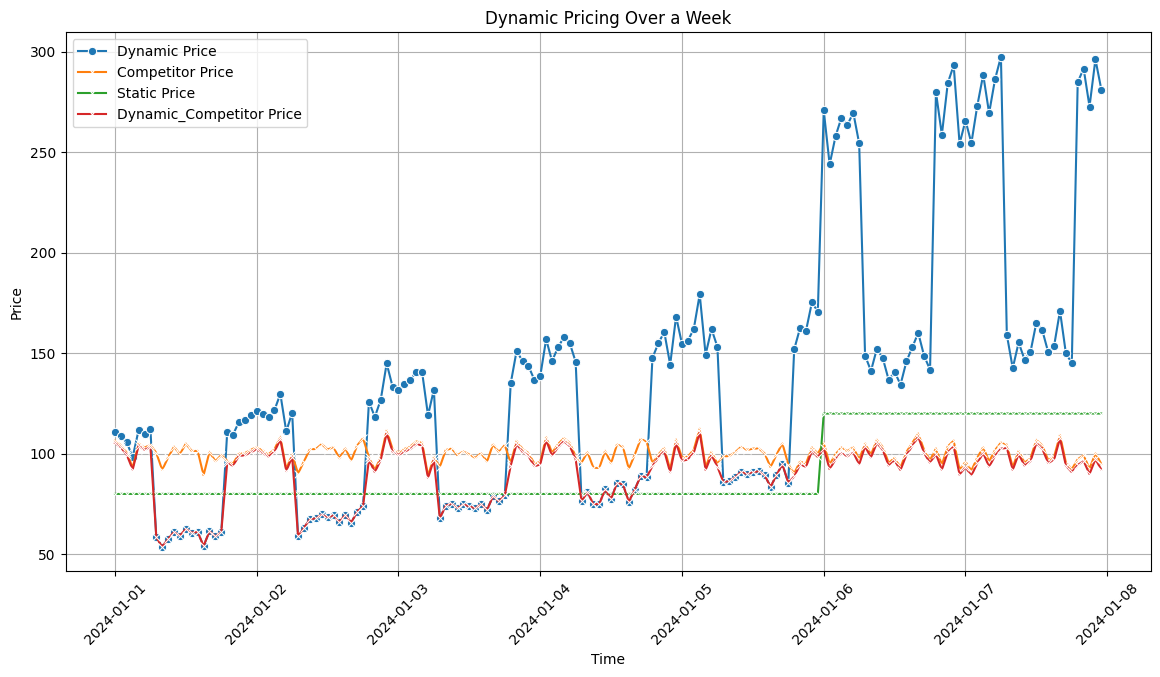

In [185]:
# 데이터 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(x='time', y='dynamic_price', data=data, marker='o', label='Dynamic Price')
sns.lineplot(x='time', y='competitor_price', data=data, marker='x', label='Competitor Price')
sns.lineplot(x='time', y='static_price', data=data, marker='x', label='Static Price')
sns.lineplot(x='time', y='dynamic_price_with_compe', data=data, marker='x', label='Dynamic_Competitor Price')
plt.title('Dynamic Pricing Over a Week')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## 가설 검증
다이나믹 프라이싱 전략의 효과를 검증하기 위해 다음과 같은 가설을 설정할 수 있습니다.

- 기존 : 요일성만 반영한
- 가설 1 : 다이나믹 프라이싱을 적용하면 (기존 대비) 수익이 증가할 것이다
- 가설 2 : 다이나믹 프라이싱을 적용하면 재고 소진 시간이 적절히 조절될 것이다.

이를 검증하기 위해 다이나믹 프라이싱 전후의 매출, 수익, 재고 데이터를 비교 분석할 수 있습니다. 실제 비즈니스에서는 A/B test 를 통해 다이나믹 프라미싱의 효과를 더욱 정확하게 측정해볼 수 있을거에요. 우선, 테스트를 위해 생성한 데이터셋으로 진행해보겠습니다.


In [186]:
# 가설 1 비교
dynamic_revenue = data['dynamic_demand'] * data['dynamic_price']
dynamic_with_comp_revenue = data['dynamic_demand'] * data['dynamic_price_with_compe']
static_revenue = data['static_demand'] * data['static_price']

print('dynamic pricing 수익:', sum(dynamic_revenue))
print('dynamic_with_comp 수익:', sum(dynamic_with_comp_revenue))
print('static pricing 수익:', sum(static_revenue))

# 경쟁사 가격만 고려해서는 static pricing 보다 낮은 이익을 얻게 되는 경우가 생깁니다
# 하지만 dynamic pricing 에 정말 수요가 있는지 확인하는 것도 필수 입니다

dynamic pricing 수익: 368361.94615323545
dynamic_with_comp 수익: 435875.5283987024
static pricing 수익: 806400.0


In [187]:
data.head()

,time,hour,day,stock_level,competitor_price,static_price,dynamic_price,static_demand,dynamic_demand,static_revenue,dynamic_revenue,remaining_stock_static,remaining_stock_dynamic,stock_usage_static,stock_usage_dynamic,dynamic_price_with_compe
0,2024-01-01 00:00:00,0,0,100.000000,106.437173,80.0,110.694660,60.0,44.652670,4800.0,4942.812125,9940.0,9955.347330,60.0,44.652670,105.330226
1,2024-01-01 01:00:00,1,0,99.461078,104.239628,80.0,108.993455,60.0,45.503273,4800.0,4959.558886,9880.0,9909.844057,60.0,45.503273,103.149694
2,2024-01-01 02:00:00,2,0,98.922156,100.446863,80.0,105.590705,60.0,47.204648,4800.0,4984.372009,9820.0,9862.639410,60.0,47.204648,99.390956
3,2024-01-01 03:00:00,3,0,98.383234,93.036481,80.0,98.322290,60.0,50.838855,4800.0,4998.592644,9760.0,9811.800555,60.0,50.838855,92.053258
4,2024-01-01 04:00:00,4,0,97.844311,105.129285,80.0,111.691367,60.0,44.154316,4800.0,4931.655968,9700.0,9767.646238,60.0,44.154316,104.012372


In [188]:
# 남은 재고 비교
total_remaining_stock_static = data['remaining_stock_static'].iloc[-1]
total_remaining_stock_dynamic = data['remaining_stock_dynamic'].iloc[-1]

print(f"Total Remaining Stock (Static Pricing): {total_remaining_stock_static}")
print(f"Total Remaining Stock (Dynamic Pricing): {total_remaining_stock_dynamic}")

if total_remaining_stock_dynamic < total_remaining_stock_static:
    print("가설 2 채택: 다이나믹 프라이싱을 적용하면 재고 소진 시간이 적절히 조절됩니다.")
else:
    print("가설 2 기각: 다이나믹 프라이싱을 적용해도 재고 소진 시간이 적절히 조절되지 않습니다.")

Total Remaining Stock (Static Pricing): 880.0
Total Remaining Stock (Dynamic Pricing): 4626.342522835099
가설 2 기각: 다이나믹 프라이싱을 적용해도 재고 소진 시간이 적절히 조절되지 않습니다.
